In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import plotly.express as px
import geopandas as gpd

In [119]:
stations = pd.read_csv('11.17.25_Bluebikes_Station_List.csv', skiprows=1)
print(stations.head())

# Define the given latitude and longitude (center point)
center_lat = stations['Lat'].mean()
center_lon = stations['Long'].mean()

# Function to calculate distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance to the center for each row
stations['distance_to_center'] = haversine(stations['Lat'], stations['Long'], center_lat, center_lon)
stations['far_from_center'] = stations['distance_to_center'] > 4


   Number                               NAME        Lat       Long  \
0  C32083  Washington St at Walsh Playground  42.277195 -71.069556   
1  C32067       Washington St at Peters Park  42.343852 -71.067646   
2  C32084         Washington St at Fuller St  42.281986 -71.071479   
3  C32081       Washington St at Denton Terr  42.280728 -71.134238   
4  C32042        Washington St at Bowdoin St  42.299165 -71.073459   

  Seasonal Status Municipality  Total Docks  \
0  Winter Storage       Boston           19   
1  Winter Storage       Boston           19   
2      Year Round       Boston           15   
3  Winter Storage       Boston           19   
4  Winter Storage       Boston           15   

  Station ID (to match to historic system data)  
0                                           430  
1                                           412  
2                                           431  
3                                           427  
4                                           25

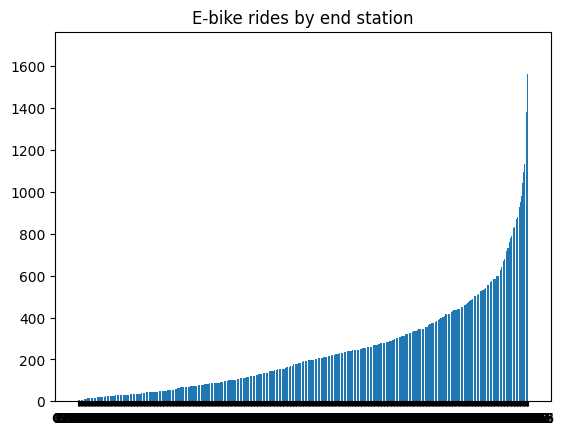

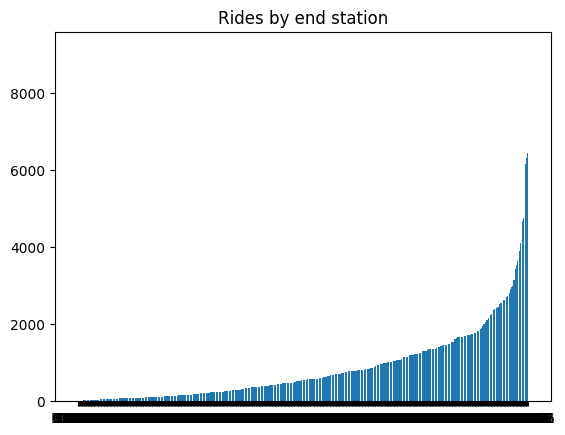

In [120]:
oct25trips = pd.read_csv('202510-bluebikes-tripdata.csv')
oct25started = oct25trips.groupby('end_station_id').describe()['start_lat']
oct25started = oct25started.sort_values(by='count')

ebikes = oct25trips[oct25trips['rideable_type'] == 'electric_bike']

ebikes_by_endpoint = ebikes.groupby('end_station_id').describe()['end_lat']
ebikes_by_endpoint = ebikes_by_endpoint.sort_values(by='count')

plt.bar(ebikes_by_endpoint.index, ebikes_by_endpoint['count'])
plt.title('E-bike rides by end station')
plt.show()

plt.bar(oct25started.index,oct25started['count'])
plt.title('Rides by end station')
plt.show()

In [121]:

stations = stations.merge(
    oct25started[['count']],
    how='left',  # Use 'left' join to keep all rows in stations
    left_on='Number',  # Column in stations to join on
    right_on=oct25started.index  # Column in oct25started to join on
)


stations = stations.merge(
    ebikes_by_endpoint[['count']],
    how='left',  # Use 'left' join to keep all rows in stations
    left_on='Number',  # Column in stations to join on
    right_on=ebikes_by_endpoint.index  # Column in oct25started to join on
)

stations = stations.rename(columns = {'count_x': 'count_all_bikes', 'count_y': 'count_ebikes'} )

# Ensure the columns are Series, not DataFrames
stations['count_all_bikes'] = stations['count_all_bikes'].squeeze()
stations['count_ebikes'] = stations['count_ebikes'].squeeze()

stations['ratio_ebikes'] = stations['count_ebikes'] / stations['count_all_bikes'].replace(0, np.nan)


print(stations.head())

   Number                               NAME        Lat       Long  \
0  C32083  Washington St at Walsh Playground  42.277195 -71.069556   
1  C32067       Washington St at Peters Park  42.343852 -71.067646   
2  C32084         Washington St at Fuller St  42.281986 -71.071479   
3  C32081       Washington St at Denton Terr  42.280728 -71.134238   
4  C32042        Washington St at Bowdoin St  42.299165 -71.073459   

  Seasonal Status Municipality  Total Docks  \
0  Winter Storage       Boston           19   
1  Winter Storage       Boston           19   
2      Year Round       Boston           15   
3  Winter Storage       Boston           19   
4  Winter Storage       Boston           15   

  Station ID (to match to historic system data)  distance_to_center  \
0                                           430            9.334084   
1                                           412            2.392088   
2                                           431            8.783920   
3           

In [122]:
from matplotlib.colors import to_hex
import branca.colormap as colm
# Create a folium map centered at the average latitude and longitude
station_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)
threshold_red = 0.3
cm = plt.get_cmap('cool')



# Create a colormap using branca that matches the matplotlib colormap
colormap = colm.LinearColormap(
    colors=[to_hex(plt.get_cmap('cool')(i)) for i in range(256)],
    vmin=stations['ratio_ebikes'].min(),
    vmax=stations['ratio_ebikes'].max(),
    caption='Ratio of E-Bikes'  # Add a caption for the color bar
)

# Add CircleMarkers for each station
for _, row in stations.iterrows():

    color = to_hex(cm(row['ratio_ebikes']))
    
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius= max( (row['count_ebikes']) // 70,3),  # Marker size
        color= color, #'blue' if row['ratio_ebikes'] > threshold_red else 'red',
        fill=True,
        fill_color= color, #'blue' if row['ratio_ebikes'] > threshold_red else 'red',
        fill_opacity=0.6,
        popup=f"Name: {row['NAME']}, e-bike count: {row['count_ebikes']}"  # Optional popup with station name
    ).add_to(station_map)
    
# Add the colormap to the map
colormap.add_to(station_map)

display(station_map)

Most dense ebikes :                                          NAME  count_ebikes  ratio_ebikes  \
503                   Bowdoin St at Quincy St         213.0      0.862348   
112                             Swan St. Park         117.0      0.835714   
563  606 American Legion Hwy at Canterbury St          86.0      0.834951   
370                Four Corners/Geneva T Stop          75.0      0.824176   
345                                 Hale Park          56.0      0.811594   
428           Commonwealth Ave at Fidelis Way         143.0      0.803371   
2                  Washington St at Fuller St          28.0      0.800000   
486                      Broadway at Maple St         120.0      0.794702   
3                Washington St at Denton Terr         101.0      0.789062   
250                          Mattapan Library          31.0      0.775000   

     far_from_center  
503             True  
112             True  
563             True  
370             True  
345             T

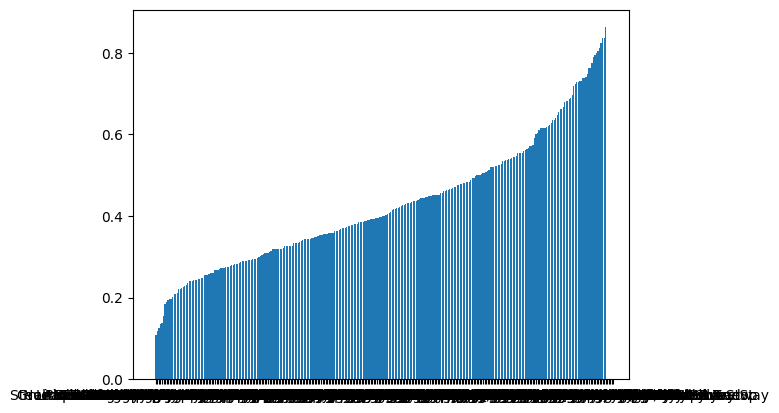

In [123]:
stations_sorted = stations[stations['far_from_center'] == True].sort_values(by='ratio_ebikes')

# print(f"Most dense ebikes : {stations.loc[stations['ratio_ebikes'].idxmax()]['NAME']}")
print(f"Most dense ebikes : {stations.nlargest(10, 'ratio_ebikes')[['NAME', 'count_ebikes', 'ratio_ebikes', 'far_from_center']]}")
print(f"Most total ebikes : {stations.nlargest(10, 'count_ebikes')[['NAME', 'count_ebikes','ratio_ebikes', 'far_from_center']]}")


plt.bar(stations_sorted['NAME'], stations_sorted['count_ebikes'] / stations_sorted['count_all_bikes'])
plt.show()

/var/folders/30/gx8zdjbn1kj6374g8qglnrtw0000gs/T/ipykernel_16161/749790041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])
/var/folders/30/gx8zdjbn1kj6374g8qglnrtw0000gs/T/ipykernel_16161/749790041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])


       end_station_id                ended_at              started_at  \
83927          A32000 2025-10-01 07:28:16.905 2025-10-01 07:24:13.095   
69291          A32000 2025-10-01 11:31:02.051 2025-10-01 11:17:04.138   
398546         A32000 2025-10-01 11:50:24.140 2025-10-01 11:44:07.119   
83533          A32000 2025-10-01 13:38:17.325 2025-10-01 13:33:37.063   
8563           A32000 2025-10-01 14:57:26.876 2025-10-01 14:41:21.520   

                 elapsed_time  
83927  0 days 04:02:45.146000  
69291  0 days 00:19:22.089000  
398546 0 days 01:47:53.185000  
83533  0 days 01:19:09.551000  
8563   0 days 00:45:23.389000  


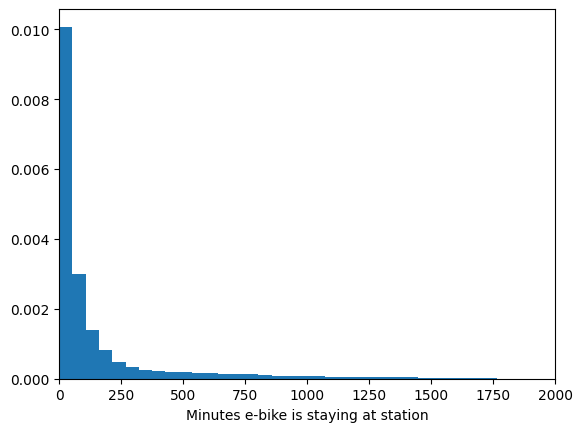

In [124]:
import pandas as pd

# Ensure 'ended_at' and 'started_at' are in datetime format
ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])
ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])

# Sort the DataFrame by 'station' and 'ended_at'
ebikes = ebikes.sort_values(by=['end_station_id', 'ended_at'])

# Shift columns to get the next row's values
ebikes['next_started_at'] = ebikes['ended_at'].shift(-1)
ebikes['next_start_station'] = ebikes['end_station_id'].shift(-1)

# Calculate elapsed time only if the end station matches the next start station
ebikes['elapsed_time'] = ebikes.apply(
    lambda row: row['next_started_at'] - row['ended_at']
    if row['end_station_id'] == row['next_start_station'] else pd.NaT,
    axis=1
)

# Display the DataFrame with the new column
print(ebikes[['end_station_id', 'ended_at', 'started_at', 'elapsed_time']].head())

ebikes['elapsed_time'] = ebikes['elapsed_time'].apply(lambda x: x.total_seconds()// 60)

plt.hist(ebikes['elapsed_time'], bins=400, density=True)
plt.xlim((0,2000))
plt.xlabel('Minutes e-bike is staying at station')
plt.show()

involves_city
True     0.870659
False    0.129341
Name: proportion, dtype: float64


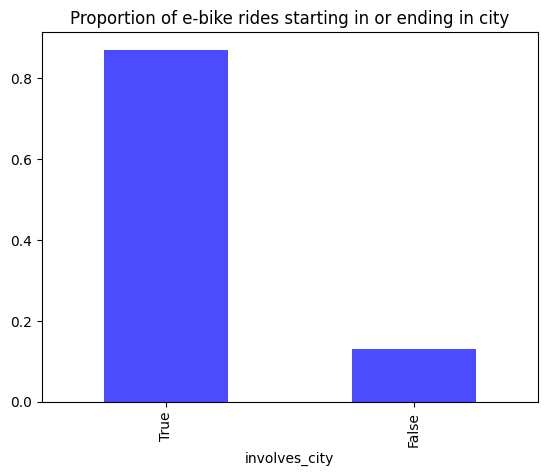

In [125]:
# Get the station IDs where 'far_from_center' is False
near_center_stations = stations.loc[stations['far_from_center'] == False, 'Number']

# Check if start_station_id or end_station_id is in the list of near-center stations
ebikes['involves_city'] = ebikes['start_station_id'].isin(near_center_stations) | ebikes['end_station_id'].isin(near_center_stations)

city_rides = ebikes['involves_city'].value_counts(normalize=True)
print(city_rides)

city_rides.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Proportion of e-bike rides starting in or ending in city')
plt.show()

involves_suburbs
False    0.64381
True     0.35619
Name: proportion, dtype: float64


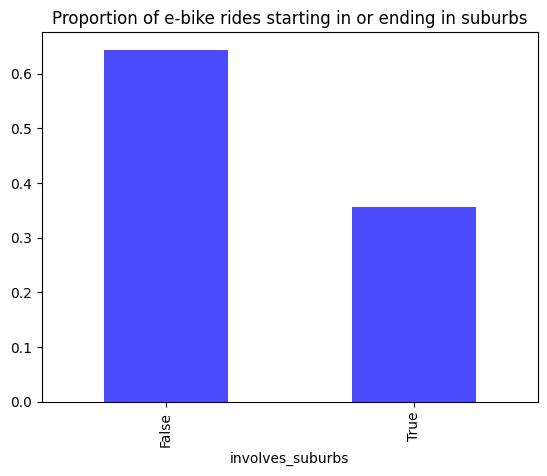

In [127]:
# what fraction of e-bike rides involve at least one point from from center

# Get the station IDs where 'far_from_center' is False
far_center_stations = stations.loc[stations['far_from_center'] == True, 'Number']

# Check if start_station_id or end_station_id is in the list of near-center stations
ebikes['involves_suburbs'] = ebikes['start_station_id'].isin(far_center_stations) | ebikes['end_station_id'].isin(far_center_stations)

suburb_rides = ebikes['involves_suburbs'].value_counts(normalize=True)
print(suburb_rides)

suburb_rides.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Proportion of e-bike rides starting in or ending in suburbs')
plt.show()


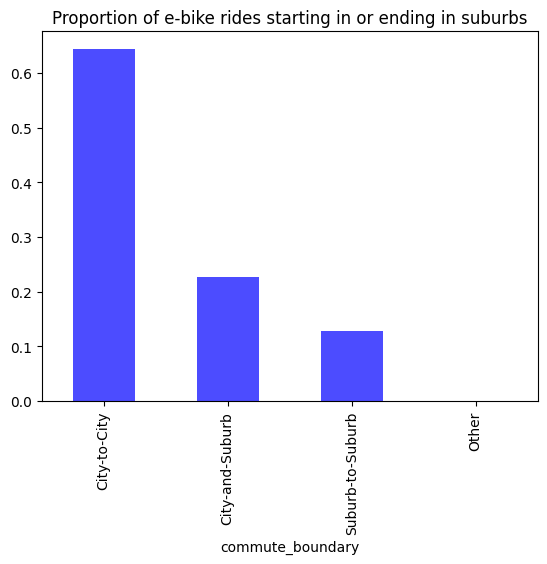

In [132]:
# city-to-city, "long haul" commute, or suburb-to-suburb
# Define the conditions
conditions = [
    (ebikes['involves_city'] == True) & (ebikes['involves_suburbs'] == False),  # CC
    (ebikes['involves_city'] == True) & (ebikes['involves_suburbs'] == True),   # CS
    (ebikes['involves_city'] == False) & (ebikes['involves_suburbs'] == True)   # SS
]

# Define the corresponding values
choices = ['City-to-City', 'City-and-Suburb', 'Suburb-to-Suburb']

# Create the new column
ebikes['commute_boundary'] = np.select(conditions, choices, default='Other')

commutes = ebikes['commute_boundary'].value_counts(normalize=True)

commutes.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Proportion of e-bike rides starting in or ending in suburbs')
plt.show()
